This notebook is tryting to identify eddies length L by operating spatial correlations on u-u_bar. 

(The stp1 - stp 3 notebooks tried to analyze the L based on u2 -u_bar2.)

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy   as np
import glob
import matplotlib.cm as cm
from scipy import stats
from ArcticTools import map
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
deep= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['deep'][:]
shallow= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['shalow'][:]
nav_lat= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lat'][:]
nav_lon= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lon'][:]
e3t= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e3t_0'][0,:]
e1t= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e1t'][0,400:,:]
e2t= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e2t'][0,400:,:]
tmask= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['tmask'][0,:,400:,:]

In [4]:
Bathy=nc.Dataset('/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=Bathy.variables['Bathymetry'][400:,:]

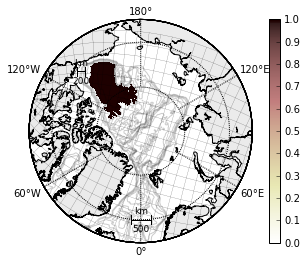

In [5]:
m,x_lon,y_lat = map.mapping(65)
m.pcolor(x_lon,y_lat,deep,cmap='pink_r');plt.colorbar()
m.drawmapscale(0, 70, 0, 0, 500)
m.drawmapscale(-135, 71, 0, 0, 200)

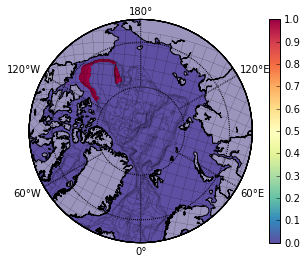

In [6]:
# prepare map
m,x_lon,y_lat = map.mapping(65)
# select the Canada Basin
shallow[nav_lat>78]=0;shallow[nav_lon<-160]=0;shallow[bathy< 500]=0
# visualize the shallow region
m.pcolor(x_lon,y_lat,shallow,cmap='Spectral_r');plt.colorbar()

In [7]:
def load_velsqu(vel_comp,year,dsfile,layer = 30):
    '''
    This function is designed to obtain (square)velocity field
    '''
    vels ={'usq':'usqure','vsq':'vsqure'}
    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_sqr_vel/EXH005*%s*%s*.nc'%(vel_comp,year))[0]) as velocity:
        data  = velocity.variables[vels[vel_comp]][0,layer,400:,:]
    #data  = np.ma.masked_where(dsfile[layer,...] == 0,data)  # if land is masked, correlations have nan
    data[dsfile[layer,...] == 0] = 0                          # just turn it into 0
    return data

In [8]:
def load_vel(vel_comp,year,dsfile,filenum,layer = 30):
    '''
    This function is designed to obtain velocity field
    filenum: # of five-day file in the list; should have (365/5) = 73 files in a year.
    dsfile: choose deep or shallow mask files
    '''
    vels ={'U':'udiff','V':'vdiff'}
    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_udiff/%s*EXH005*%s*.nc'%(vel_comp,year))[filenum]) as velocity:
        data  = velocity.variables[vels[vel_comp]][0,layer,400:,:]
    #data  = np.ma.masked_where(dsfile[layer,...] == 0,data)  # if land is masked, correlations have nan
    data[dsfile[layer,...] == 0] = 0                          # just turn it into 0
    return data

In [24]:
def correlation_curve_one_year(year,num,vkey = 'U',key = 'x'):
    '''num: float, has to > 0; the gird number that shifts
       vkey: velocity key 'usq' or 'vsq' or 'tot'
       key : direction key 'x' or 'y'
    '''
    
    '''allocation'''
    length = \
    len(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_udiff/%s*EXH005*%s*.nc'%(vkey,year)))
    data1 = np.zeros((length,e1t.shape[0],e1t.shape[1]));data2 = np.zeros_like(data1);
    correlation = np.zeros_like(e1t)

    '''load data'''
    for filenum in range (length):
        data = load_vel(vkey,year,filenum=filenum,dsfile=tmask,layer = 30)
        if num ==0 :
            # nothing move
            data1[filenum,:,:] = data;data2[filenum,:,:] = data 
        else:
            if key =='y':
                # nemo has a dimension in (y,x) instead of (x,y)
                data1[filenum,num:,:]=data[num:,:]
                data2[filenum,num:,:]=data[:-num,:]
            if key =='x':
                data1[filenum,:,num:]=data[:,num:]
                data2[filenum,:,num:]=data[:,:-num]
    '''correlation'''
    for i in range(data1.shape[1]):
            for j in range(data1.shape[2]):
                correlation[i, j] = np.corrcoef(data1[:,i,j], data2[:,i,j])[0,1] 
    # focusing on the Canada basin
    cbasin = deep + shallow
    correlation[cbasin==0]=np.nan
    return np.nanmean(correlation)

### Explore how the basin-averaged correlation changes when the grid 'slides' away..
on the U component first

In [ ]:
# play with different grid shifting distances 
# variable shift: the # of grid that moved away from the original location in x or y direction
shift = np.linspace(0,10,11)
shifts = np.hstack((shift,np.linspace(20,50,4)))
shifts

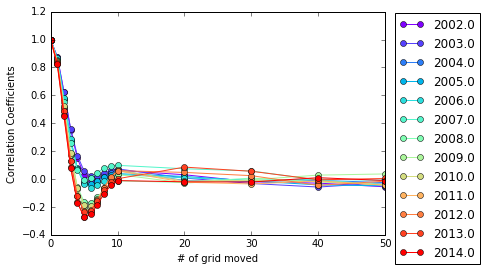

In [27]:
'''r: array to contain correlation coefficients'''
r = {'year':[],'shift':[],'r':[]}

for y,c in zip(year,colors):
    for gridshift in shifts: 
        avgcorr = correlation_curve_one_year(int(y),gridshift,vkey = 'U',key = 'y')
        r['year'].append(y)
        r['shift'].append(gridshift)
        r['r'].append(avgcorr);

for y,c in zip(year,colors):
    x    = np.array(r['shift'])[r['year']==y]
    corr = np.array(r['r'])[r['year']==y]
    plt.plot(x,corr,'-o',c=c,label = y)
    plt.legend(loc=1, bbox_to_anchor=(1.3, 1.02))
    plt.xlabel('# of grid moved')
    plt.ylabel('Correlation Coefficients')
# moved u-grid in y direction

Thoughts - U moved in y direction: 

Correlation coefficients changes from positive to negative. The zero crossing occurs when the grid is moved away for approx. 4 grids, suggesting the length is about the size of 4 grids. Also noted that in recent years, the appearence of zero crossing requires less shifts (eg. in 2014, the zero-crossing shows up when the grid slides only 2 grids away), indicating eddies are becoming smaller in size.

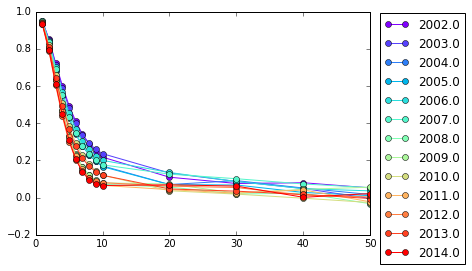

In [23]:
year = np.linspace(2002,2014,13)
colors = cm.rainbow(np.linspace(0, 1, 13))
'''r: array to contain correlation coefficients'''
r = {'year':[],'shift':[],'r':[]}

for y,c in zip(year,colors):
    for gridshift in shifts: 
        avgcorr = correlation_curve_one_year(int(y),gridshift,vkey = 'U',key = 'x')
        r['year'].append(y)
        r['shift'].append(gridshift)
        r['r'].append(avgcorr);

for y,c in zip(year,colors):
    x    = np.array(r['shift'])[r['year']==y]
    corr = np.array(r['r'])[r['year']==y]
    plt.plot(x,corr,'-o',c=c,label = y)
    plt.legend(loc=1, bbox_to_anchor=(1.3, 1.02))
    plt.xlabel('# of grid moved')
    plt.ylabel('Correlation Coefficients')
# moved u-grid in x direction

Thoughts - U moved in x direction: 

In a moving-range between 0 and 50 grids, the corr. coeff. stays positive. The turning point  normally occurrs when the grid is moved @ approx. 5-10 grids away. But with time goes by, we can see a drop in the value of the corr. coeff.. It suggests the u component is having a larger variation in the x direction than it used to be. ( -> means a more flutuating fluid field. Because of an increasing number of eddies? or weaker convergence/divergence?)

### Now do the same analysis on V

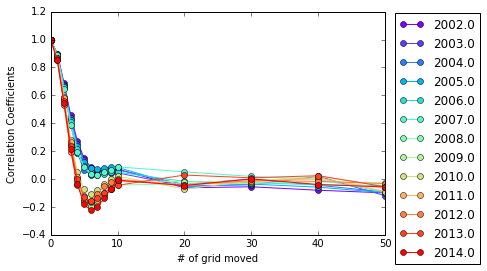

In [ ]:
'''r: array to contain correlation coefficients'''
r = {'year':[],'shift':[],'r':[]}

for y,c in zip(year,colors):
    for gridshift in shifts: 
        avgcorr = correlation_curve_one_year(int(y),gridshift,vkey = 'V',key = 'x')
        r['year'].append(y)
        r['shift'].append(gridshift)
        r['r'].append(avgcorr);

for y,c in zip(year,colors):
    x    = np.array(r['shift'])[r['year']==y]
    corr = np.array(r['r'])[r['year']==y]
    plt.plot(x,corr,'-o',c=c,label = y)
    plt.legend(loc=1, bbox_to_anchor=(1.3, 1.02))
    plt.xlabel('# of grid moved')
    plt.ylabel('Correlation Coefficients')
# moved v-grid in x direction

In [ ]:
'''r: array to contain correlation coefficients'''
r = {'year':[],'shift':[],'r':[]}

for y,c in zip(year,colors):
    for gridshift in shifts: 
        avgcorr = correlation_curve_one_year(int(y),gridshift,vkey = 'V',key = 'y')
        r['year'].append(y)
        r['shift'].append(gridshift)
        r['r'].append(avgcorr);

for y,c in zip(year,colors):
    x    = np.array(r['shift'])[r['year']==y]
    corr = np.array(r['r'])[r['year']==y]
    plt.plot(x,corr,'-o',c=c,label = y)
    plt.legend(loc=1, bbox_to_anchor=(1.3, 1.02))
    plt.xlabel('# of grid moved')
    plt.ylabel('Correlation Coefficients')
#moved v-grid in y direction


Next move, use the eddy length identified above to estimate mixing time scale.

- T = S/(U*L) 
- examinate L: 4 grid points